In [1]:
%matplotlib notebook 
import json
import numpy 
import os
import sys
import time

import skimage.io
import skimage.transform
import skimage.color
import skimage.feature 
import skimage.measure

import scipy.signal
import scipy.ndimage

import matplotlib.pyplot
import matplotlib.patches

# Create bounding boxes for all non mitotic cells
This notebook performs three tasks
1. Bounding boxes for all reference cells are created 
2. All bounding boxes for mitotic cells are removed 
3. The remaining bounding boxes are enlarged by a defined offset 

In [2]:
data_dir = '../data/'
filename_mitosis = data_dir + 'bbox_mitosis.json' 
mask_dir = data_dir + 'mask/'
image_dir = '../data/cetres.b_adapted/'
offset = 12

In [3]:
def to_dict(x1, y1, x2, y2):
    return {
        "class": "cell",
        "x1": y1,
        "x2": y2,
        "y1": x1,
        "y2": x2
    }

def box_list(pathname):
    image = skimage.io.imread(pathname)
    region_list = skimage.measure.regionprops(image)
    return [to_dict(*region.bbox) for region in region_list]

# load image given the image number
def getImage(frameNr, image_dir):
    imageName = 'refdataB_C2_' + "%03i.png" % (frameNr,)
    image =  skimage.io.imread(image_dir + imageName)
    return skimage.color.rgb2gray(image)

# helper function to create the image given the frame number
def getImageName(frameNr, image_dir):
    return('refdataB_C2_' + "%03i.png" % (frameNr,))


# Read reference data
All reference images are loaded and all stored masks are stored as a bbox. Remember that this list includes all cells including mitotic cells!

In [4]:
# read all cell masks 
import glob

pathnames = glob.glob(mask_dir + "ref*.png")

template_list = []

for pathname in pathnames:
    template = {
        "boxes": box_list(pathname),
        "filename": os.path.basename(pathname),
        "shape" : [1376, 1038, 3]
    }
    
    template_list += [template]

## Load bounding boxes of all mitotic cells 
These data is created using the notebook  ```2017_06_create_mitosis_bbox_template_matching```

In [5]:
# load mitotic cells 

with open(filename_mitosis, "r") as f:
    mitosis_list = json.loads(f.read())

In [6]:
# sort the stuff 
sorted_mitosis_list = sorted(mitosis_list, key=lambda element: element["filename"])
sorted_cell_list = sorted(template_list, key=lambda element: element["filename"])
sorted_mitosis_list[1]

{'boxes': [{'class': 'mitosis', 'x1': 410, 'x2': 451, 'y1': 30, 'y2': 71}],
 'filename': 'refdataB_C2_014.png',
 'shape': [1376, 1038, 3]}

## Sample image

In [7]:
I_cell = skimage.io.imread("../data/cetres.b_adapted/refdataB_C2_014.png")

fig, ax = matplotlib.pyplot.subplots(figsize=(10, 6))
ax.imshow(I_cell,cmap="gray")     
    
minr, minc, maxr, maxc = [38, 419, 61, 442]
rect = matplotlib.patches.Rectangle((minc, minr), maxc - minc, 
                                    maxr - minr, fill = False, edgecolor = 'red', 
                                    linewidth = 2)
ax.add_patch(rect)

minr, minc, maxr, maxc = [30, 410, 71, 451]
rect = matplotlib.patches.Rectangle((minc, minr), maxc - minc, 
                                    maxr - minr, fill = False, edgecolor = 'blue', 
                                    linewidth = 2)
ax.add_patch(rect)

<IPython.core.display.Javascript object>

## Remove mitotic cells 

In [8]:
def norm2(x1,x2,y1,y2):
    return (numpy.sqrt((x1-x2)*(x1-x2) + (y1 - y2)*(y1 - y2)))

def same_bounding_box(bbox1, bbox2):
    x1 = 1/2 * (bbox1["x1"] + bbox1["x2"]) 
    x2 = 1/2 * (bbox2["x1"] + bbox2["x2"]) 
    y1 = 1/2 * (bbox1["y1"] + bbox1["y2"]) 
    y2 = 1/2 * (bbox2["y1"] + bbox2["y2"])
    return (norm2(x1,x2,y1,y2) < 15)

def remove_duplicates(mito_list, cell_list):
    bad_cells = []

    for mito_box in mito_list["boxes"]:
        for cell_box in cell_list["boxes"]:
            if same_bounding_box(cell_box, mito_box):
                bad_cells += [cell_box]
                break

    for bad_cell in bad_cells:
        try:
            cell_list["boxes"].remove(bad_cell)
        except ValueError as e:
            continue
            
    return bad_cells

In [9]:
duplicate_cells = []

for mito_list in sorted_mitosis_list:
    for cell_list in sorted_cell_list:
        if cell_list["filename"][-7:] == mito_list["filename"][-7:]:
            duplicate_cells += [remove_duplicates(mito_list, cell_list)] 

## Enlarge bounding boxes 

In [10]:
x,y,z = skimage.io.imread('../data/cetres.b/refdataB_C2_001.png').shape
print(x,y)


1038 1376


In [11]:

for element in sorted_cell_list:
    print(element["filename"])
    for box in element["boxes"]:
        box["x1"] = max(0, box["x1"] - offset)
        box["x2"] = min(y, box["x2"] + offset)
        box["y1"] = max(0, box["y1"] - offset)
        box["y2"] = min(x, box["y2"] + offset)
        if (box["x1"] > box["x2"]):
            print("x1 > x2!")
        if (box["y1"] > box["y2"]):
            print("y1 > y2! ")

refdataB_C2_001.png
refdataB_C2_002.png
refdataB_C2_003.png
refdataB_C2_004.png
refdataB_C2_005.png
refdataB_C2_006.png
refdataB_C2_007.png
refdataB_C2_008.png
refdataB_C2_009.png
refdataB_C2_010.png
refdataB_C2_011.png
refdataB_C2_012.png
refdataB_C2_013.png
refdataB_C2_014.png
refdataB_C2_015.png
refdataB_C2_016.png
refdataB_C2_017.png
refdataB_C2_018.png
refdataB_C2_019.png
refdataB_C2_020.png
refdataB_C2_021.png
refdataB_C2_022.png
refdataB_C2_023.png
refdataB_C2_024.png
refdataB_C2_025.png
refdataB_C2_026.png
refdataB_C2_027.png
refdataB_C2_028.png
refdataB_C2_029.png
refdataB_C2_030.png
refdataB_C2_031.png
refdataB_C2_032.png
refdataB_C2_033.png
refdataB_C2_034.png
refdataB_C2_035.png
refdataB_C2_036.png
refdataB_C2_037.png
refdataB_C2_038.png
refdataB_C2_039.png
refdataB_C2_040.png
refdataB_C2_041.png
refdataB_C2_042.png
refdataB_C2_043.png
refdataB_C2_044.png
refdataB_C2_045.png
refdataB_C2_046.png
refdataB_C2_047.png
refdataB_C2_048.png
refdataB_C2_049.png
refdataB_C2_050.png


In [12]:
with open('../data/bbox_cells_enlarged.json', 'w') as fp:
    json.dump(sorted_cell_list, fp, indent=4)

In [16]:
# todo: write iterator over images to find entries for 
#
def get_frame_data(cell_list, frame):
    filename = 'refdataB_C2_' + "%03i.png" % (frame)
    matches = [x for x in cell_list if x['filename'] == filename]
    if not matches:
        return []
    else:
        return(matches[0])
    
print(get_frame_data(sorted_mitosis_list,1))
print(get_frame_data(sorted_cell_list,1))

[]
{'boxes': [{'class': 'cell', 'x1': 494, 'x2': 560, 'y1': 380, 'y2': 426}, {'class': 'cell', 'x1': 788, 'x2': 855, 'y1': 781, 'y2': 830}, {'class': 'cell', 'x1': 835, 'x2': 883, 'y1': 798, 'y2': 847}, {'class': 'cell', 'x1': 662, 'x2': 719, 'y1': 782, 'y2': 835}, {'class': 'cell', 'x1': 396, 'x2': 472, 'y1': 752, 'y2': 801}, {'class': 'cell', 'x1': 824, 'x2': 870, 'y1': 989, 'y2': 1030}, {'class': 'cell', 'x1': 982, 'x2': 1031, 'y1': 378, 'y2': 425}, {'class': 'cell', 'x1': 957, 'x2': 1000, 'y1': 378, 'y2': 420}, {'class': 'cell', 'x1': 630, 'x2': 677, 'y1': 172, 'y2': 223}, {'class': 'cell', 'x1': 997, 'x2': 1054, 'y1': 868, 'y2': 916}, {'class': 'cell', 'x1': 86, 'x2': 150, 'y1': 28, 'y2': 91}, {'class': 'cell', 'x1': 1130, 'x2': 1177, 'y1': 512, 'y2': 563}, {'class': 'cell', 'x1': 1076, 'x2': 1116, 'y1': 0, 'y2': 14}, {'class': 'cell', 'x1': 342, 'x2': 409, 'y1': 36, 'y2': 77}, {'class': 'cell', 'x1': 1032, 'x2': 1078, 'y1': 224, 'y2': 275}, {'class': 'cell', 'x1': 281, 'x2': 344,

<IPython.core.display.Javascript object>


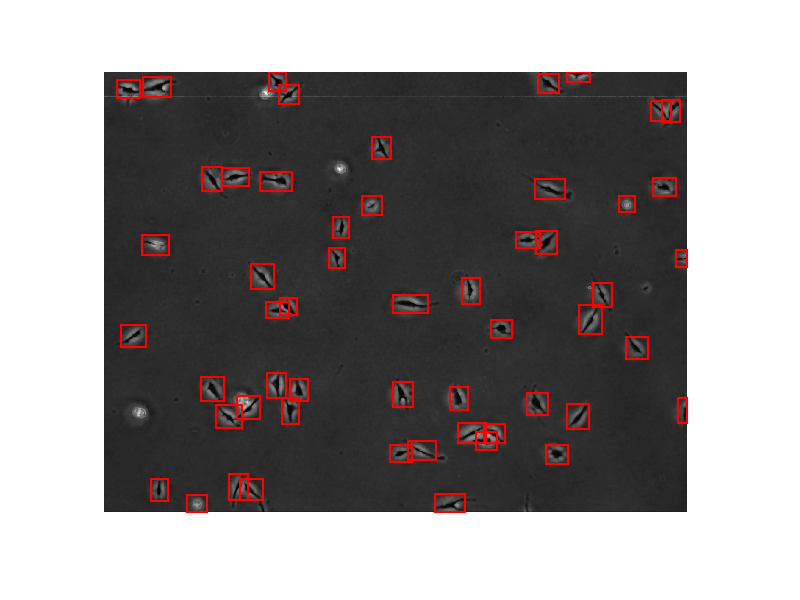

In [14]:
# using matplotlib we can updated the figure each iteration 
fig, ax = matplotlib.pyplot.subplots(figsize=(8, 6))

frame_one = sorted_cell_list[1]

    
    
for frame in range(100,101,1):   
    # clear axis to remove patches (rect objects)
    matplotlib.pyplot.cla()
    cellImage = getImage(frame, image_dir)
    ax.imshow(cellImage,cmap='gray')
    matplotlib.pyplot.axis('off')
    # ignore frames without mitotic events
    
    frame_data = get_frame_data(sorted_cell_list, frame)
    #print(frame, frame_data)
    if frame_data:
        for box in frame_data["boxes"]:
            x1 = box['x1']
            x2 = box['x2'] 
            y1 = box['y1'] 
            y2 = box['y2']
            matplotlib.pyplot.plot([x1, x2], [y1, y1], 'r-')
            matplotlib.pyplot.plot([x1, x2], [y2, y2], 'r-')
            matplotlib.pyplot.plot([x2, x2], [y1, y2], 'r-')
            matplotlib.pyplot.plot([x1, x1], [y1, y2], 'r-')
    fig.canvas.draw()    